In [1]:
import sys
import os
import pandas as pd
import numpy as np
from pyspark.mllib.feature import StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder.config("spark.executor.pyspark.memory", "6g") \
        .config("spark.executor.memory", "6g").config("spark.driver.memory", "6g") \
        .config("spark.driver.maxResultSize", "6g").getOrCreate()

22/03/09 15:37:01 WARN Utils: Your hostname, sandeep-pc resolves to a loopback address: 127.0.1.1; using 192.168.29.58 instead (on interface enp4s0)
22/03/09 15:37:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/03/09 15:37:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
df = spark.read.csv('hdfs://localhost:9000/user/sandeep/data/datasetfinal.csv', sep=',', inferSchema=True, header=True).select("Duration","Dst_bytes","Flag","Hot","Num_compromised","Count","Serror_rate","Rerror_rate","Same_srv_rate","Diff_srv_rate","Srv_count","Srv_serror_rate","Srv_rerror_rate","Srv_diff_host_rate","Dst_host_count","Dst_host_srv_count","Dst_host_same_srv_rate","Dst_host_diff_srv_rate","Dst_host_same_src_port_rate","Dst_host_srv_diff_host_rate","Dst_host_serror_rate","Dst_host_srv_serror_rate","Dst_host_rerror_rate","class","class_index")

In [26]:
# df = spark.read.csv('hdfs://localhost:9000/user/sandeep/data/datasetfinal.csv', sep=',', inferSchema=True, header=True)

In [4]:
spark.sparkContext

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
df.dtypes

[('Duration', 'int'),
 ('Dst_bytes', 'int'),
 ('Flag', 'int'),
 ('Hot', 'int'),
 ('Num_compromised', 'int'),
 ('Count', 'int'),
 ('Serror_rate', 'int'),
 ('Rerror_rate', 'double'),
 ('Same_srv_rate', 'double'),
 ('Diff_srv_rate', 'double'),
 ('Srv_count', 'double'),
 ('Srv_serror_rate', 'double'),
 ('Srv_rerror_rate', 'double'),
 ('Srv_diff_host_rate', 'double'),
 ('Dst_host_count', 'int'),
 ('Dst_host_srv_count', 'int'),
 ('Dst_host_same_srv_rate', 'double'),
 ('Dst_host_diff_srv_rate', 'double'),
 ('Dst_host_same_src_port_rate', 'double'),
 ('Dst_host_srv_diff_host_rate', 'double'),
 ('Dst_host_serror_rate', 'double'),
 ('Dst_host_srv_serror_rate', 'double'),
 ('Dst_host_rerror_rate', 'double'),
 ('class', 'string'),
 ('class_index', 'double')]

In [6]:
catcols = [x for (x, dataType) in df.dtypes if dataType == "string"]
numcols = [x for (x, dataType) in df.dtypes if ((dataType =="int") | (dataType == "double") & (x != "class_index"))]

In [7]:
numcols

['Duration',
 'Dst_bytes',
 'Flag',
 'Hot',
 'Num_compromised',
 'Count',
 'Serror_rate',
 'Rerror_rate',
 'Same_srv_rate',
 'Diff_srv_rate',
 'Srv_count',
 'Srv_serror_rate',
 'Srv_rerror_rate',
 'Srv_diff_host_rate',
 'Dst_host_count',
 'Dst_host_srv_count',
 'Dst_host_same_srv_rate',
 'Dst_host_diff_srv_rate',
 'Dst_host_same_src_port_rate',
 'Dst_host_srv_diff_host_rate',
 'Dst_host_serror_rate',
 'Dst_host_srv_serror_rate',
 'Dst_host_rerror_rate']

In [8]:
from pyspark.ml.feature import StandardScaler, VectorAssembler 
vector_assembler = VectorAssembler(inputCols = numcols, outputCol = "features")
temptrain = vector_assembler.setHandleInvalid("skip").transform(df).select("class_index","features")

In [9]:
# temptrain.select("class_index","features").show(5)

In [10]:
df = StandardScaler(inputCol = "features", outputCol="scaledfeatures").fit(temptrain).transform(temptrain)

22/03/09 15:37:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
train, test = df.randomSplit([0.7, 0.3], seed = 2022)

In [12]:
train.select("scaledfeatures").show(5)

+--------------------+
|      scaledfeatures|
+--------------------+
|(23,[1,5,6,11,14,...|
|(23,[1,5,6,11,14,...|
|(23,[1,5,6,11,14,...|
|(23,[1,5,6,11,14,...|
|(23,[1,5,6,11,14,...|
+--------------------+
only showing top 5 rows



In [13]:
rf = RandomForestClassifier(featuresCol = 'scaledfeatures', labelCol = 'class_index').fit(train)

In [36]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol = 'scaledfeatures', labelCol = 'class_index').fit(train)

In [14]:
predictions = rf.transform(test)

In [37]:
predictionsnb = nb.transform(test)

In [15]:
predictions.show()

+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|class_index|            features|      scaledfeatures|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|        0.0|(23,[1,5,6,11,14,...|(23,[1,5,6,11,14,...|[0.11546930116684...|[0.00577346505834...|       2.0|
|        0.0|(23,[1,5,6,11,14,...|(23,[1,5,6,11,14,...|[0.11615704168048...|[0.00580785208402...|       2.0|
|        0.0|(23,[1,5,6,11,14,...|(23,[1,5,6,11,14,...|[6.08245729550204...|[0.30412286477510...|       2.0|
|        0.0|(23,[1,5,6,11,14,...|(23,[1,5,6,11,14,...|[6.08245729550204...|[0.30412286477510...|       2.0|
|        0.0|(23,[1,5,6,11,14,...|(23,[1,5,6,11,14,...|[6.08314503601568...|[0.30415725180078...|       2.0|
|        0.0|(23,[1,5,6,11,14,...|(23,[1,5,6,11,14,...|[6.08314503601568...|[0.30415725180078...|       2.0|
|        0.0|(23,[1

In [38]:
predictionsnb.show()

+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|class_index|            features|      scaledfeatures|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|        0.0|(38,[1,19,20,25,2...|(38,[1,19,20,25,2...|[-16.326623933595...|[0.94166141903755...|       0.0|
|        0.0|(38,[1,19,20,25,2...|(38,[1,19,20,25,2...|[-20.703139636030...|[0.98169194286753...|       0.0|
|        0.0|(38,[1,19,20,25,2...|(38,[1,19,20,25,2...|[-22.131360104008...|[0.99999851259307...|       0.0|
|        0.0|(38,[1,19,20,25,2...|(38,[1,19,20,25,2...|[-22.192102777966...|[0.99999857173088...|       0.0|
|        0.0|(38,[1,19,20,25,2...|(38,[1,19,20,25,2...|[-30.499643890638...|[0.99999987004010...|       0.0|
|        0.0|(38,[1,19,20,25,2...|(38,[1,19,20,25,2...|[-30.630267216006...|[0.99999987923256...|       0.0|
|        0.0|(38,[1

In [16]:
evaluator = MulticlassClassificationEvaluator( labelCol="class_index", predictionCol="prediction", metricName="accuracy")

In [17]:
accuracy = evaluator.evaluate(predictions)
accuracy

0.9953292361242934

In [40]:
accuracy = evaluator.evaluate(predictionsnb)
accuracy

0.9176162979382643

In [20]:
# rf.featureImportances

<BarContainer object of 23 artists>

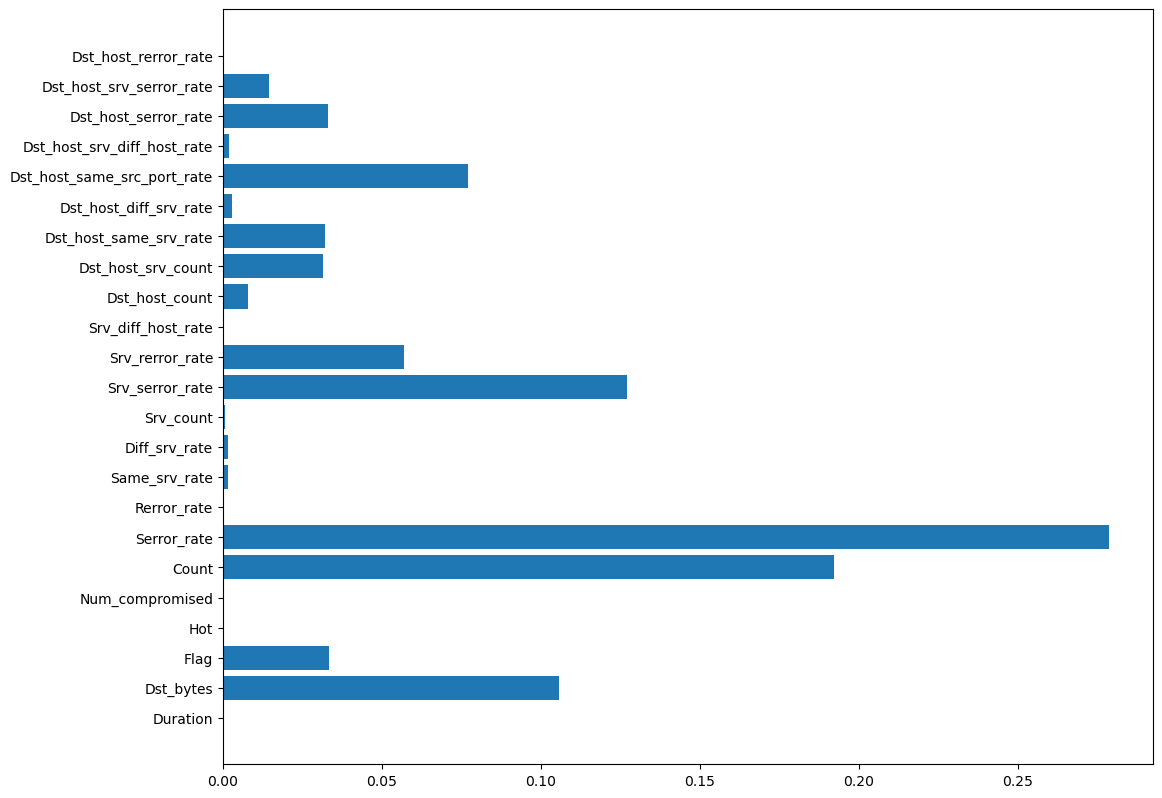

In [18]:
figure(figsize=(12, 10), dpi=100)
plt.barh(numcols, rf.featureImportances)

In [23]:
# train = VectorSlicer(inputCol="scaledfeatures", outputCol="ssifeatures").setIndices(0,1).transform(train)

In [20]:
# df.select("ssifeatures").show(10)